# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение, количество
детей клиента и пр., на факт погашения кредита в срок. Входные данные от банка — статистика о
платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной
системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Описание исходных данных
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years ` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

# <a name="contents">Содержание</a>
## [1. Ознакомление с данными](#stage_1)
   
        

## [2. Предобработка данных](#stage_2)
    - выделение лемм для целей кредита
    - проверка статистической значимости различий между группами
    - поиск пропусков и аномалий в данных, их обработка
    - категоризация

## [3. Ответы на вопросы](#stage_3)
    - Есть ли зависимость между наличием детей и возвратом кредита в срок?
    - Есть ли зависимость между семейным положением и возвратом кредита в срок?
    - Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
    - Как разные цели кредита влияют на его возврат в срок?


## [4. Результаты исследования](#stage_4)
    - Общие выводы
    - Рекомендации

<a name="stage_1"></a>
# 1. Ознакомление с данными.


[Наверх к оглавлению](#contents)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(16, 8)})

import re

from pymystem3 import Mystem
from collections import Counter

import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scikit_posthocs as sp

In [2]:
path = r'C:\Users\USER\Desktop\Обучение 2020\Яндекс Практикум\Project_1\data.csv'
df = pd.read_csv(path)

In [3]:
# посмотрим на имеющиеся данные
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [4]:
# посмотрим на общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
# посмотрим на описательную статистику числовых колонок
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


* В колонке с количеством детей, максимальное значение 20, такое может быть, но необходимо проверить. Также в этой колонке имеются отрицательные значения.
* В колонке со стажем работы имеются как положительные, так и отрицательные значения. Также имеются пропуски в заполнении.
* В колонке с возрастом есть значения равные 0.
* В колонке с уровнем образования уже можно заметить ошибки в регистре

В следующем разделе нужно рассмотреть каждую колонку подробнее.

In [6]:
# посмотрим на описательную статистику остальных колонок
df.describe(include='object')

,education,family_status,gender,income_type,purpose
count,21525,21525,21525,21525,21525
unique,15,5,3,8,38
top,среднее,женат / замужем,F,сотрудник,свадьба
freq,13750,12380,14236,11119,797


* В колонке с гендерным признаком 3 уникальных значения.

In [7]:
# посмотрим на количество уникальных значений во всех колонках
df.nunique()

children                8
days_employed       19351
dob_years              58
education              15
education_id            5
family_status           5
family_status_id        5
gender                  3
income_type             8
debt                    2
total_income        19351
purpose                38
dtype: int64

In [8]:
# проверим строки на дубликаты
df.duplicated().sum()

54

Дубликаты удалим. После исправления ошибок в заполнении колонок, сделаем еще одну проверку.

In [9]:
# проверим строки на пропуски
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В столбцах со стажем и месячным доходом *(days_employed и total_income)* имеется одинаковое количество незаполненных значений, возможно это записи одних и тех же людей. Это могут быть молодые люди без опыта работы или те, кто работал неофициально, нужно проверить и правильно заполнить пропуски.

In [10]:
# посмотрим на названия колонок
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

* Название колонки 'total_income' не очень информативно. Ведь это может быть общая зарплата семьи или годовая зарплата этого клиента. В рамках проекта будем считать, что это месячная зарплата. Переименуем колонку в соответствии с этим выводом.
* Название колонки 'dob_years' заставляет задуматься, дадим более простое название.

<a name="stage_2"></a>
# 2. Предобработка данных


[Наверх к оглавлению](#contents)

In [11]:
# переименуем колонки для удобства восприятия
df.rename(columns={'dob_years':'age', 'total_income':'month_income'}, inplace=True)

In [12]:
# удалим дубликаты
df.drop_duplicates(inplace=True)

In [13]:
# обновим индексы
df.reset_index(drop=True, inplace=True)

## Посмотрим на колонки по отдельности

Начнем с колонок, в которых нет пропусков и явных аномалий, т.к. они могут понадобиться для восстановления информации в других колонках.

## 2.1 Колонка с целью кредита

In [14]:
# посмотрим на уникальные значения
df.purpose.unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Для дальнейшего удобства в анализе данных, выполним категоризацию данных

In [15]:
# Создадим строку со всеми уникальными целями
all_purposes = ' '.join(df.purpose.unique())

# Лемматизируем полученную строку
m = Mystem()
lemmas = m.lemmatize(all_purposes)

# Подсчитаем количество каждого слова из строки
Counter(lemmas)

Counter({'покупка': 10,
         ' ': 96,
         'жилье': 7,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 2,
         'свой': 4,
         'со': 1,
         'заниматься': 2,
         'сделка': 2,
         'получение': 3,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1,
         '\n': 1})

На первый взгляд можно выделить следующие категории по целям на кредит: недвижимость (жилье), автомобиль, свадьба, образование. Нужно проверить, все ли цели клиентов попадают в предполагаемые категории. Ведь мы могли что-то упустить, или предполагаемые категории могли упоминаться в одной цели.

In [16]:
# создадим список с целями кредита
purposes_list = df.purpose.unique().tolist()

In [17]:
# создадим паттерн по предполагаемым 4 группам и проверим, все ли значения в списке уникальных целей подходят под паттерн
pattern = 'недв|жиль|авто|свад|образ'
count = 0
for purpose in purposes_list:
    if re.search(pattern, purpose):
        count+=1
print (f'Количество строк попавших под паттерн = {count} из {len(purposes_list)}')

Количество строк попавших под паттерн = 38 из 38


Делаем вывод, что каждая из уникальных целей попадает под одну из 4х категорий и не попадает одновременно под две и более.

In [18]:
# создадим функцию, которая изменит значения в колонке в соответствии с нашими группами
def purposes_to_group(row):
    purpose_dict = {'недв|жиль' : 'недвижимость',
                 'авто'      : 'автомобиль',
                 'свад'      : 'свадьба',
                 'образ'     : 'образование'}
    
    for pattern in purpose_dict:
        if re.search(pattern, row):
            return purpose_dict[pattern]

In [19]:
# применим функцию к колонке
df['purpose_group'] = df['purpose'].apply(purposes_to_group)

In [20]:
# посмотрим на распределение клиентов по целям
df['purpose_group'].value_counts()

недвижимость    10814
автомобиль       4308
образование      4014
свадьба          2335
Name: purpose_group, dtype: int64

## 2.2 Колонки с образованием

In [21]:
# посмотрим на уникальные значения и распределение клиентов по ним
df.education.value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [22]:
# Приведем все значения к одному регистру
df.education = df.education.str.lower()

In [23]:
# Посмотрим на распределение
df.education.value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [24]:
# Проверим на соответствие id_education и уровня образования
df.groupby(['education','education_id']).agg({'gender':'count'}).sort_values('education_id')

,,gender
education,education_id,
высшее,0,5251
среднее,1,15188
неоконченное высшее,2,744
начальное,3,282
ученая степень,4,6


Логика в присвоении id_education не прослеживается. Просто удалим эту колонку, т.к. колонка с образованием сама по себе является довольно репрезентативной и понятной

In [25]:
# удаление колонки
df.drop(columns='education_id', inplace=True)

## 2.3 Колонка с типом занятости

In [26]:
# посмотрим на распределение значений
df.income_type.value_counts()

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Все выглядит вполне естественно: берзаботным, студентам и женщинам в декрете редко дают кредиты. Удалим строчки с этими клиентами, т.к. их очень мало и эти выборки не будут репрезентативными. Предпринимателей тоже мало, но их можно отнести их к категории "компаньон".

In [27]:
# Найдем индексы строк, которые нужно удалить
income_type_to_drop = ['безработный', 'студент', 'в декрете']
index_to_drop = df.query("income_type in @income_type_to_drop").index
index_to_drop

Int64Index([3132, 9403, 14775, 20795], dtype='int64')

In [28]:
# Удаляем лишние строки
df = df.drop(index=index_to_drop).reset_index(drop=True)

In [29]:
# Заменим тип занятости 'предприниматель' на 'компаньон'
df['income_type'] = df['income_type'].replace('предприниматель', 'компаньон')

Text(0.5, 1.0, 'Распределение клиентов в зависимости от типа занятости')

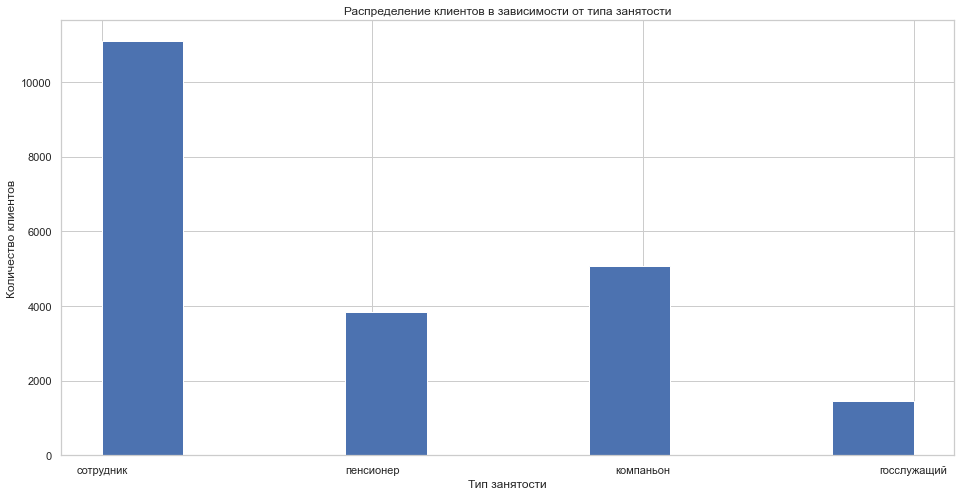

In [30]:
# Посмотрим на получившееся распределение значений
df.income_type.hist()
plt.xlabel("Тип занятости")
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов в зависимости от типа занятости')

Text(0.5, 1.0, 'Распределение возраста клиентов пенсионеров')

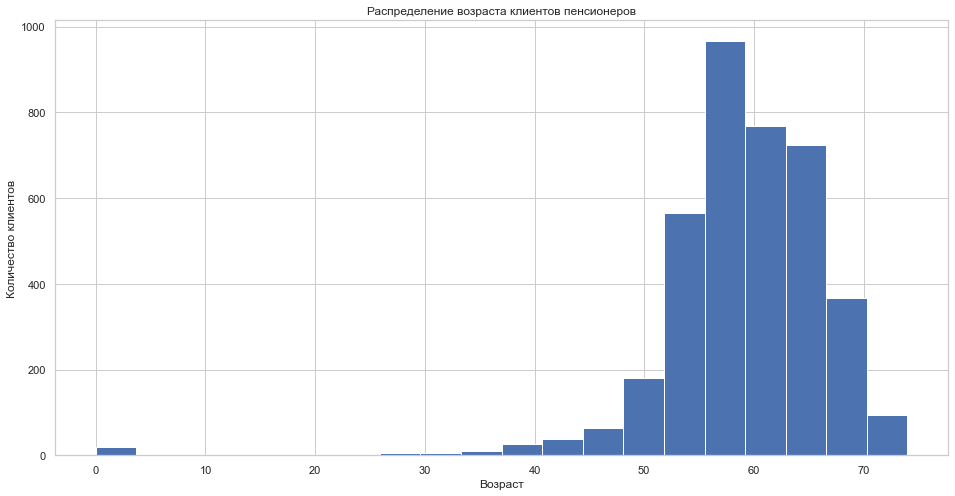

In [31]:
# Посмотрим на распределение возраста для пенсионеров, 
# т.к. это единственный тип занятости имеющий отношение к столбцу с возрастом
df.query("income_type == 'пенсионер'").age.hist(bins=20)
plt.xlabel("Возраст")
plt.ylabel('Количество клиентов')
plt.title('Распределение возраста клиентов пенсионеров')

Мы знаем, что часть значений в столбце с возрастом, у нас = 0, мы можем видеть результат этого в распределении возраста пенсионеров. Эту проблему мы разберем позже. 

На что нужно обратить внимание, так это на то, что возраст у пенсионеров начинается с 25 лет. Но таких случае мало, и это тоже нормально. Это могут быть инвалиды, которых раньше отправляют на пенсию или госслужащие, которые тоже уходят на пенсию раньше.

## 2.4 Колонка с разделением по половому признаку

In [32]:
# посмотрим на распределение значений
df.gender.value_counts(normalize=True)

F      0.660875
M      0.339079
XNA    0.000047
Name: gender, dtype: float64

1. Распределение по половому признаку выглядит не совсем типично. Количество женщин, взявших кредит в 2 раза больше чем мужчин. Хотя мировой опыт говорит о том, что женщины берут чаще кредиты на мелкие покупки в ТК, нежели такие категории как *Недвижимость*, *Автомобиль*, *Свадьба* и *Образование*. 
2. 3й гендерный тип по всей видимости является опечаткой.

Text(0.5, 1.0, 'Распределение клиентов в зависимости от цели кредита и пола')

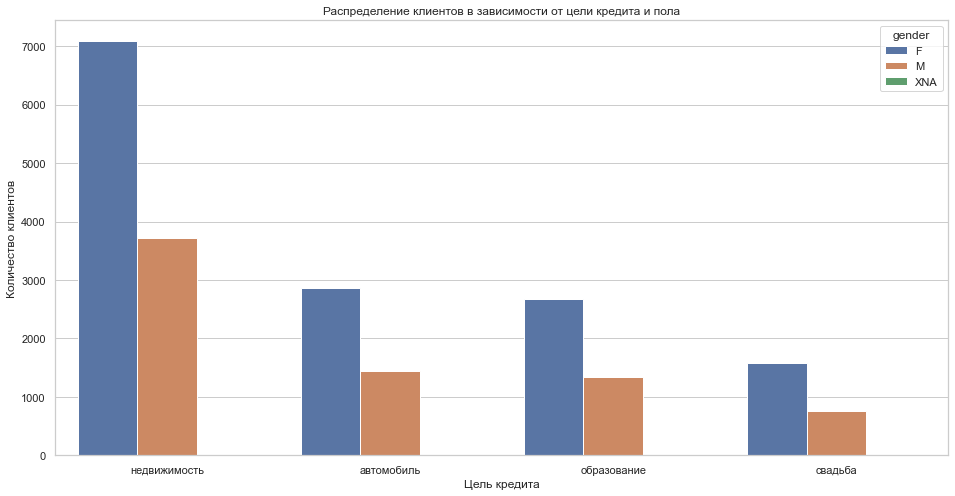

In [33]:
# Интересно посмотреть на респределение целей кредита в зависимости от пола
sns.countplot('purpose_group', data = df, hue='gender')
plt.xlabel("Цель кредита")
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов в зависимости от цели кредита и пола')

Распределение для мужчин и женщин выглядит вполне пропорциональным. Будем считать, что у нас выборка в которой больще женщин.

In [34]:
# посмотрим на строку со значением XNA
df.query("gender == 'XNA'")

,children,days_employed,age,education,family_status,family_status_id,gender,income_type,debt,month_income,purpose,purpose_group
10688,0,-2358.600502,24,неоконченное высшее,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости,недвижимость


Данные о клиенте ничего нам не говорят о его половом признаке, и т.к. такой клиент всего один, мы можем его удалить.

In [35]:
# Найдем индексы строк, которые нужно удалить
gender_to_drop = ['XNA']
index_to_drop = df.query("gender == 'XNA'").index
index_to_drop

Int64Index([10688], dtype='int64')

In [36]:
# Удаляем строку
df = df.drop(index=index_to_drop).reset_index(drop=True)

### Колонки с семейным статусом

In [37]:
# посмотрим на распределение
df.family_status.value_counts()

женат / замужем          12342
гражданский брак          4161
Не женат / не замужем     2809
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

In [38]:
# приведем все строки к одному регистру
df.family_status = df.family_status.str.lower()

Text(0.5, 1.0, 'Распределение клиентов в зависимости от семейного статуса')

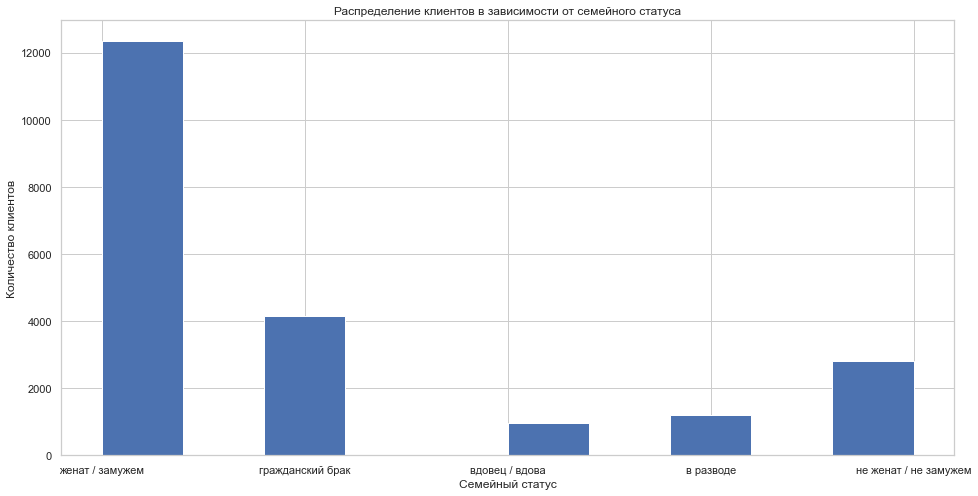

In [39]:
# Еще раз посмотрим на распределение
df.family_status.hist()
plt.xlabel("Семейный статус")
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов в зависимости от семейного статуса')

In [40]:
# проверим на соответствие family_status_id и семейного статуса
df.groupby(['family_status','family_status_id']).agg({'gender':'count'}).sort_values('family_status_id')

,,gender
family_status,family_status_id,
женат / замужем,0,12342
гражданский брак,1,4161
вдовец / вдова,2,959
в разводе,3,1195
не женат / не замужем,4,2809


Значения выгледят вполне логичными.

In [41]:
# проверим данные на наличие дублирующихся строк
df.duplicated().sum()

17

Скорее всего дубликаты появились после приведения столбца с образованием и семейным положением к одному регистру

In [42]:
# удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

### Колонка по наличию задолжности

In [43]:
df.debt.value_counts(normalize=True)

0    0.918924
1    0.081076
Name: debt, dtype: float64

Распределение выглядит логичным.

## 2.5 Колонка по наличию детей

In [44]:
# посммотрим на распределение значений
df.children.value_counts()

 0     14088
 1      4807
 2      2051
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

1. Отрицательные значения скорее всего ошибка при записи, возьмем значения по модулю. 
2. Количество детей равное 20, чисто теоретически возможно, но совсем выбивается из нашего распределения 3е детей - 330, 4ро детей - 41, 5ро детей - 9 и 20 детей - 76.
3. P.S. Самое большое число детей, рожденных одной матерью, по официальным данным, - 69.

Text(0.5, 1.0, 'Количество детей у клиентов в зависимости от возраста')

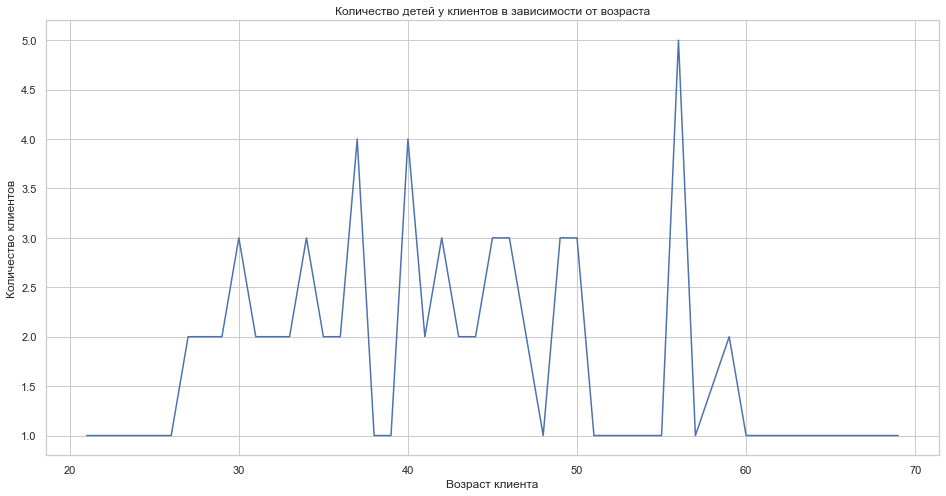

In [45]:
# посмотрим на распределение по возрасту для людей с таким количеством детей
# заранее убурем из выборки людей с нулевым возрастом
df.query('children == 20 and age>0').groupby('age')['children'].count().plot()
plt.xlabel("Возраст клиента")
plt.ylabel('Количество клиентов')
plt.title('Количество детей у клиентов в зависимости от возраста')

На графике видно, что возраст людей с 20ю детьми начинается от 21 года, что даже теоретически не возможно (если они не усыновили всех этих детей). В любом случае, возростной интервал совсем не тот. Все факты говорят в пользу того, что количество 20 детей, это ошибка в данных. Можно сделать предположение, что количество детей на самом деле равно 2, а 0 это опечатка.

In [46]:
# заменим значения с 20 детьми на 2
df.children = np.where(df.children == 20, 2, df.children)

# избавимся от отрицательных значений
df.children = df.children.abs()

In [47]:
# проверим распределение значений
df.children.value_counts()

0    14088
1     4854
2     2127
3      330
4       41
5        9
Name: children, dtype: int64

Т.к. данных по количеству клиентов с 4мя и 5ю детьми мало, для дальнейшего анализа, выполним категоризацию данных. Создадим новую колонку children_group, в которой разделим клиентов на 4 группы по количеству детей: нет детей, 1 ребенок, 2 детей, 3 и более детей

In [48]:
# создаем новую колонку с 4мя группами
df['children_group'] = pd.cut(df.children, [-0.1,0.1,1.1,2.1,5.1],
                              labels=['нет детей', '1 ребенок', '2 детей', '3 и более детей'])

In [49]:
df['children_group'].value_counts()

нет детей          14088
1 ребенок           4854
2 детей             2127
3 и более детей      380
Name: children_group, dtype: int64

## 2.6 Колонка со стажем

In [50]:
# посмотрим на описательную статистику
df.days_employed.describe()

count     19346.000000
mean      63025.234315
std      140809.084684
min      -18388.949901
25%       -2747.486276
50%       -1203.438174
75%        -291.146144
max      401755.400475
Name: days_employed, dtype: float64

1. Информация, выраженная в количестве дней, трудно воспринимается. Нужно перевести данные в количество по годам.
2. У нас есть как отрицательные, так и положительные значения. Нужно понять, по какому признаку происходит разделение.

In [51]:
# создадим новый столбец
# переведем данные в значения по годам и округлим до целого
# исправить тип данных пока не возможно, т.к. в столбце есть NaN
df['years_employed'] = df.days_employed.div(365).round()

In [52]:
# посмотрим на описательную статистику в годах
df.years_employed.describe()

count    19346.000000
mean       172.671095
std        385.779032
min        -50.000000
25%         -8.000000
50%         -3.000000
75%         -1.000000
max       1101.000000
Name: years_employed, dtype: float64

Посмотрим на отрицательные и положительные значения по отдельности

In [53]:
# посмотрим на положительные значения
df.query('years_employed > 0').years_employed.describe()

count    3443.000000
mean     1000.009585
std        57.736681
min       901.000000
25%       950.000000
50%      1001.000000
75%      1050.000000
max      1101.000000
Name: years_employed, dtype: float64

Положительные значения стажа работы больше максимальной продолжительности жизни людей. Эти значения точно неверные.

In [54]:
# посмотрим на распределение типа занятости у этих людей
df.query('years_employed > 0').income_type.value_counts()

пенсионер    3443
Name: income_type, dtype: int64

In [55]:
#посмотрим сколько всего клиентов пенсионеров
df.query('income_type == "пенсионер"').count()

children            3829
days_employed       3443
age                 3829
education           3829
family_status       3829
family_status_id    3829
gender              3829
income_type         3829
debt                3829
month_income        3443
purpose             3829
purpose_group       3829
children_group      3829
years_employed      3443
dtype: int64

In [56]:
# количество пенсионеров с незаполненным стажем работы
3837 - 3443

394

Таким образом, получается, что у всех пенсионеров данные в столбце со стажем работы посчитаны не верно (аномально большие значения). Также можно заметить, что у 394 пенсионеров, стаж работы вообще не заполнен.

In [57]:
# посмотрим на отрицательные значения
df.query('years_employed < 0').years_employed.describe()

count    15283.000000
mean        -6.709285
std          6.305112
min        -50.000000
25%         -9.000000
50%         -5.000000
75%         -2.000000
max         -1.000000
Name: years_employed, dtype: float64

Распределение отрицательных значений выглядит естественным.

In [58]:
# посмотрим на количество строк, в которых стаж или ежемесячный доход не заполненны
df[df.years_employed.isna() | df.month_income.isna()].shape[0]

2103

In [59]:
# посмотрим на количество строк когда оба столбца не заполненны
df[['years_employed', 'month_income']].isna().sum()

years_employed    2103
month_income      2103
dtype: int64

Количество строк в двух случаях совпадают, следовательно пропуски в стаже и зарплате у одних и тех же людей.

In [60]:
# посмотрим на распределение по типу занятости для этих клиентов
df[df.years_employed.isna() & df.month_income.isna()].income_type.value_counts()

сотрудник      1070
компаньон       502
пенсионер       386
госслужащий     145
Name: income_type, dtype: int64

В перечне типов занятости у этих клиентов, нет студентов или безработных, а это единственное, что могло бы обосновать пропуски в столбцах со стажем и зарплатой.

In [61]:
# посмотрим на распределение по возрасту для этих клиентов
df[df.years_employed.isna() & df.month_income.isna()].age.value_counts(bins=4)

(36.5, 54.75]      922
(18.25, 36.5]      694
(54.75, 73.0]      477
(-0.074, 18.25]     10
Name: age, dtype: int64

Распределение по возрасту, также показывает нам, что пропуски не обоснованны, т.к. большая часть людей это люди довольно зрелого возраста

Подведем итоги того, что нам нужно сделать для этого столбца:
    1. Заменить аномально высокий положительный стаж (у пенсионеров).
    2. Заполнить пропущенные значения стажа у всех типов занятости 
    3. Клиентов с 0 возрастом рассмотрим отдельно.
    4. Избавиться от отрицательных значений стажа работы

Самым логичным является заполнить стаж на основе возраста. Построим линию тренда и посчитаем чему равен коэф. детерминации двух переменных (возраста и стажа работы)

In [62]:
# отберем необходимые данные
df_pens = df.query('income_type == "пенсионер" and age != 0 and years_employed > 0')

Text(0.5, 1.0, 'Стаж работы клиентов в зависимости от возраста')

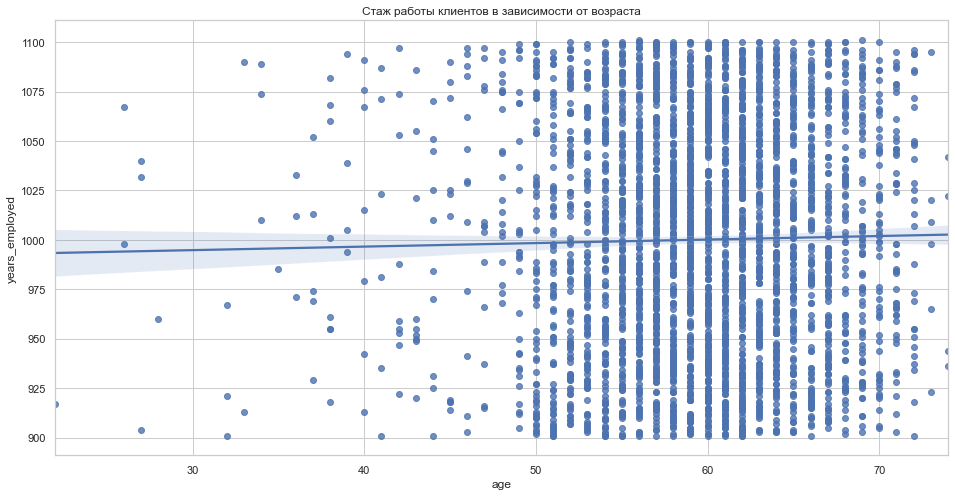

In [63]:
# визуилизируем линию тренда
sns.regplot(x = 'age', y = 'years_employed', data = df_pens)
plt.title('Стаж работы клиентов в зависимости от возраста')

In [64]:
# Посмотрим на коэффициент корелляции Пирсана
st.pearsonr(df_pens.age, df_pens.years_employed) 

(0.019580841761601922, 0.25187863137533073)

In [65]:
# Посмотрим на коэффициент корелляции Спирмана
st.spearmanr(df_pens.age, df_pens.years_employed)

SpearmanrResult(correlation=0.020522177202090458, pvalue=0.22979268383986068)

Никакой зависимости между переменными не наблюдается. Делаем вывод, что при записи значений стажа у пенсионеров, произошла ошибка и данные сохранились неправильно.

Посмотрим на зависимость между стажем и возрастом у других типов занятости. Возможно сдесь можно будет построить достоверную регрессионную модель и на ее основе заполнить возраст у пенсионеров.

In [66]:
# отберем необходимые данные
df_not_pens = df.query('income_type != "пенсионер" and age != 0 and years_employed < 0')

In [67]:
df_not_pens['years_employed'] = df_not_pens['years_employed'].abs()

<ipython-input-67-4f421e2fd023>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_pens['years_employed'] = df_not_pens['years_employed'].abs()


Text(0.5, 1.0, 'Стаж работы клиентов в зависимости от возраста')

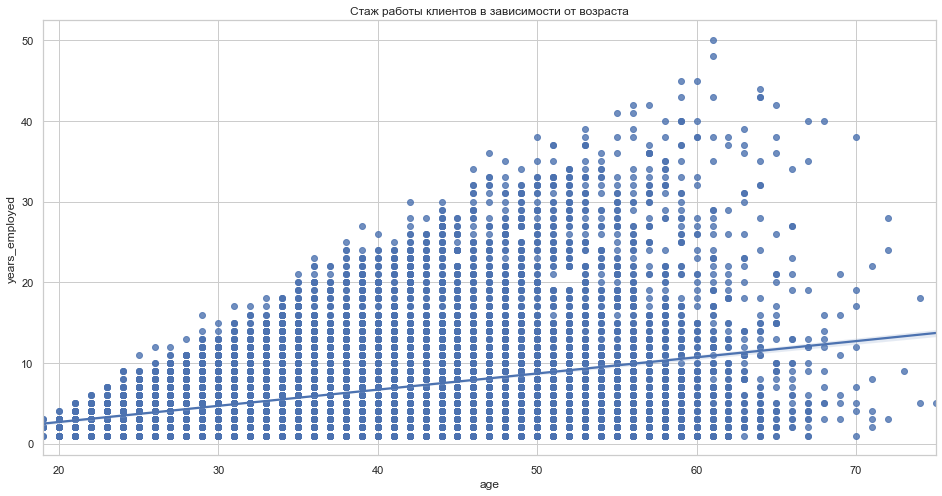

In [68]:
# визуилизируем линию тренда
sns.regplot(x = 'age', y = 'years_employed', data = df_not_pens)
plt.title('Стаж работы клиентов в зависимости от возраста')

In [69]:
# Посмотрим на коэффициент корелляции Пирсана
st.pearsonr(df_not_pens.age, df_not_pens.years_employed) 

(0.3282522926276037, 0.0)

In [70]:
# Проведем регрессионный анализ

Y = df_not_pens.age
X = df_not_pens.years_employed
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1837.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:26:04   Log-Likelihood:                -56228.
No. Observations:               15212   AIC:                         1.125e+05
Df Residuals:                   15210   BIC:                         1.125e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             36.5055      0.115    316.

По результатам регрессионного анализа можно сделать вывод, что всего 10% изменчивости стажа зависит от изменения возраста. На основе имеющейся регрессионной модели, мы не сможем достоверно заполнить пропуски в стаже у пенсионеров и у клиентов с другим типом занятости. Следовательно, необходимо:
1. Заменить некорректный стаж у пенсионеров на 'unknown'
2. Заполнить пропуски в стаже у пенсионеров и остальных типов занятости на 'unknown'

In [71]:
# Заменим некорректный значения и пропуски стажа у пенсионеров на 'unknown'
df.loc[df['income_type'] == 'пенсионер', 'years_employed'] = 'unknown'

In [72]:
# Заполним пропуски в стаже у других типов занятости на 'unknown'
df.loc[df['years_employed'].isna(), 'years_employed'] = 'unknown'

In [73]:
# Проверяем, остались ли пропуска
df['years_employed'].isna().sum()

0

Конечно, хотелось бы заполнить колонку со стажем числовыми значениями, но это должны быть значения, которые не испортят репрезентативность наших данных, поэтому мы ставим 'unknown'.

In [74]:
# Избавимся от отрицательных значений в стаже работы
df.loc[df['years_employed'] != 'unknown', 'years_employed'] = df.loc[df['years_employed'] != 'unknown', 'years_employed'].abs()

Text(0.5, 1.0, 'Количество клиентов в зависимости от стажа работы')

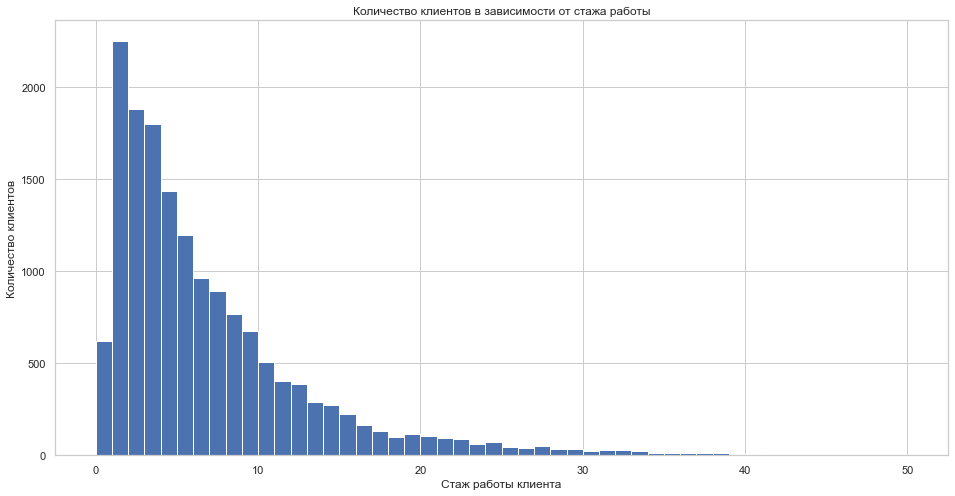

In [75]:
# Теперь посмотрим на распределение наших пользователей по стажу
df.loc[df['years_employed'] != 'unknown', 'years_employed'].hist(bins=50)
plt.xlabel("Стаж работы клиента")
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов в зависимости от стажа работы')

Распределение выглядит вполне логично.

In [76]:
# удалим колонку со стажем по дням, т.к. в ней хранится некорректная информация
df = df.drop(columns='days_employed')

## 2.7 Колонка с зарплатой

In [77]:
# Еще раз посмотрим на распределение значений
df.month_income.describe()

count    1.934600e+04
mean     1.674336e+05
std      1.029769e+05
min      2.066726e+04
25%      1.030850e+05
50%      1.450208e+05
75%      2.034396e+05
max      2.265604e+06
Name: month_income, dtype: float64

Разброс зарплат очень большой, и т.к. не удобно анализировать большие цифры, поделим значения на 1000, чтобы видеть зарплату в т.р.

In [78]:
# сейчас мы не можем преобразовать значения в целочисленные, т.к. в столбце есть NaN
df.month_income = df.month_income.div(1000).round(1)

Text(0.5, 1.0, 'Количество клиентов в зависимости от зарплаты')

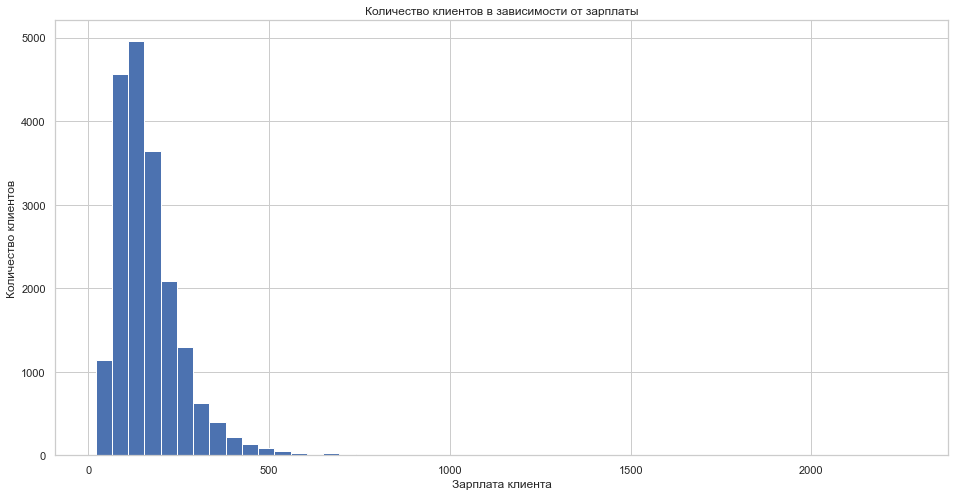

In [79]:
# Отразим распределение на графике
df.month_income.hist(bins=50)
plt.xlabel("Зарплата клиента")
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов в зависимости от зарплаты')

In [80]:
# Посмотрим на максимальное значение
df.month_income.max()

2265.6

Неплохая зарплата. Как мы видим по графику, таких клиентов очень мало.

In [81]:
# У нас имелись пропущенные значения. Посмотрим на них еще раз
df.month_income.isna().sum()

2103

In [82]:
# Посмотрим еще раз, как эти клиенты делятся по типу занятости
df.loc[df.month_income.isna(), 'income_type'].value_counts()

сотрудник      1070
компаньон       502
пенсионер       386
госслужащий     145
Name: income_type, dtype: int64

Было бы логичным, заполнить пропущенные значения в зависимости от стажа и типа занятости. Посмотрим, имеется ли такая зависимость.

In [83]:
# отберем необходимые данные
df_sotr = df.loc[(df['income_type'] == "сотрудник") & (df['month_income'].notna()) & (df['years_employed'] != "'unknown'")]
df_sotr['years_employed'] = df_sotr['years_employed'].astype('int')

<ipython-input-83-70003c206bef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sotr['years_employed'] = df_sotr['years_employed'].astype('int')


Text(0.5, 1.0, 'Распределение зарплаты клиентов в зависимости от стажа работы')

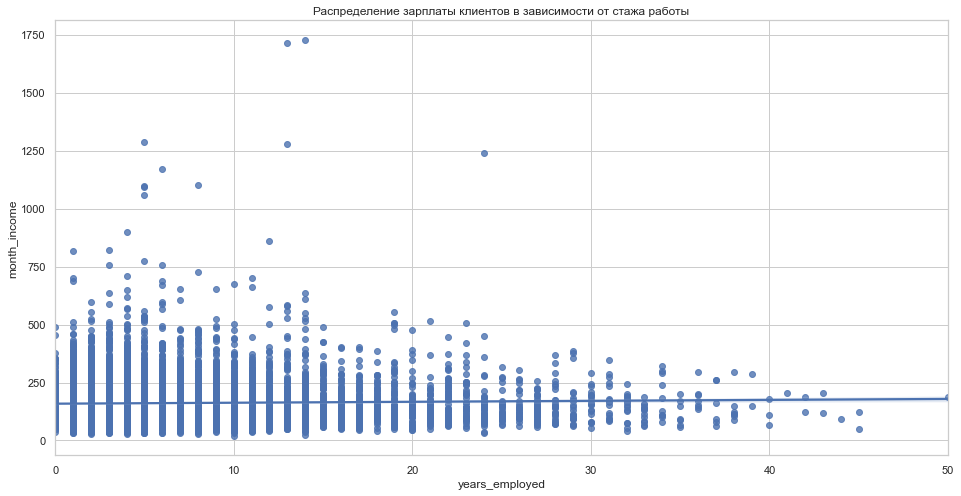

In [84]:
sns.regplot(x = 'years_employed', y = 'month_income', data = df_sotr)
plt.title('Распределение зарплаты клиентов в зависимости от стажа работы')

In [85]:
# Посмотрим на коэффициент корелляции Пирсана
st.pearsonr(df_sotr.month_income, df_sotr.years_employed)

(0.028274794586381435, 0.004659596715683546)

In [86]:
# Посмотрим на коэффициент корелляции Спирмана
st.spearmanr(df_sotr.month_income, df_sotr.years_employed) 

SpearmanrResult(correlation=0.041481369000096364, pvalue=3.291381037486679e-05)

In [87]:
# Проведем регрессионный анализ

Y = df_sotr.month_income
X = df_sotr.years_employed
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           month_income   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.011
Date:                Wed, 25 Nov 2020   Prob (F-statistic):            0.00466
Time:                        17:26:06   Log-Likelihood:                -59412.
No. Observations:               10014   AIC:                         1.188e+05
Df Residuals:                   10012   BIC:                         1.188e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            158.7786      1.295    122.

Значимой зависимости между стажем работы и зарплатой не обнаружено.

Проверим, есть ли разница в зарплате, в зависимости от типа занятости.

In [88]:
# Отберем необходимые данные
df_income = df.loc[df['month_income'].notna()]

In [89]:
# Для начала просто посмотрим на описательную статистику
df_income.groupby('income_type', as_index=False).agg({'month_income':['mean', 'median','std', 'max']})

income_type month_income                            
                       mean  median         std     max
0  госслужащий   170.898399  150.45   96.878845   910.5
1    компаньон   202.482347  172.40  130.554543  2265.6
2    пенсионер   137.127157  118.50   80.246807   735.1
3    сотрудник   161.379958  142.60   91.322724  1726.3

Text(0.5, 1.0, 'Зарплата клиентов в зависимости от типа занятости')

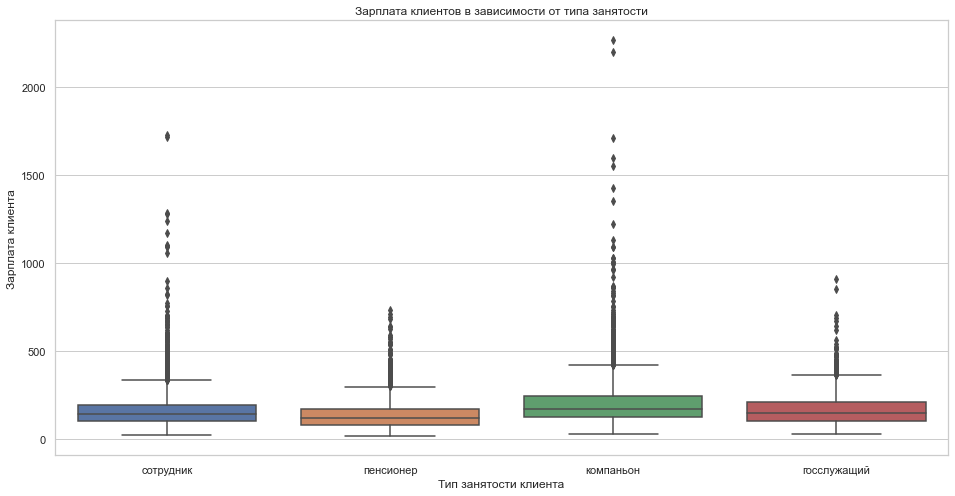

In [90]:
# Посмотрим на распределения по типу занятости
sns.boxplot(data=df_income, x='income_type', y='month_income')
plt.xlabel("Тип занятости клиента")
plt.ylabel('Зарплата клиента')
plt.title('Зарплата клиентов в зависимости от типа занятости')

Проведем дисперсионный анализ

In [91]:
# Проверяем гомогенность дисперсий
st.levene( df_income.query('income_type == "госслужащий"').month_income,
           df_income.query('income_type == "компаньон"').month_income,
           df_income.query('income_type == "пенсионер"').month_income,
           df_income.query('income_type == "сотрудник"').month_income)

LeveneResult(statistic=78.25394877663726, pvalue=2.6031002226369683e-50)

In [92]:
# Проверяем распределение каждой группы на нормальность по тесту Шапиро - Уилка.
# Для проведения теста берем небольшие выборки из каждой группы,
# т.к. данный тест становится очень чувствительным при больших выборках
st.shapiro( df_income.query('income_type == "госслужащий"').month_income.sample(1000, random_state = 17) )

ShapiroResult(statistic=0.8560157418251038, pvalue=3.004825366803582e-29)

In [93]:
st.shapiro( df_income.query('income_type == "компаньон"').month_income.sample(1000, random_state = 17) )

ShapiroResult(statistic=0.6556351184844971, pvalue=8.280272625695344e-41)

In [94]:
st.shapiro( df_income.query('income_type == "пенсионер"').month_income.sample(1000, random_state = 17) )

ShapiroResult(statistic=0.8580913543701172, pvalue=4.5007974696374437e-29)

In [95]:
st.shapiro( df_income.query('income_type == "сотрудник"').month_income.sample(1000, random_state = 17) )

ShapiroResult(statistic=0.8113808035850525, pvalue=1.2978208480094642e-32)

По результатам тестов и визуализации, мы видим, что наши группы имеют разную дисперсию и распределение далеко от нормального.

In [96]:
# Проведем дисперсионный анализ
st.f_oneway( df_income.query('income_type == "госслужащий"').month_income,
           df_income.query('income_type == "компаньон"').month_income,
           df_income.query('income_type == "пенсионер"').month_income,
           df_income.query('income_type == "сотрудник"').month_income)

F_onewayResult(statistic=301.6047304014357, pvalue=2.238744694750112e-191)

Логично, что дисперсионный анализ показывает, что различия есть, т.к. дисперсии у групп сильно отличаются.

In [97]:
# Посмотрим на непараметрический тест Крускалла Волиса (аналог дисперсионного анализа)
st.kruskal( df_income.query('income_type == "госслужащий"').month_income,
           df_income.query('income_type == "компаньон"').month_income,
           df_income.query('income_type == "пенсионер"').month_income,
           df_income.query('income_type == "сотрудник"').month_income)

KruskalResult(statistic=1078.8039414173543, pvalue=1.4438229118773133e-233)

Непарраметрический тест показывает, что хотябы одна группа значимо отличается от остальных.

In [98]:
# Выполним тест Данна с поправкой Бонферонни для p-значений
sp.posthoc_dunn( [df_income.query('income_type == "госслужащий"').month_income,
                  df_income.query('income_type == "компаньон"').month_income,
                  df_income.query('income_type == "пенсионер"').month_income,
                  df_income.query('income_type == "сотрудник"').month_income],
                  p_adjust = 'bonferroni')

,1,2,3,4
1,1.000000e+00,7.790351e-22,4.191248e-38,1.600121e-02
2,7.790351e-22,1.000000e+00,1.091377e-228,1.269956e-107
3,4.191248e-38,1.091377e-228,1.000000e+00,1.052937e-63
4,1.600121e-02,1.269956e-107,1.052937e-63,1.000000e+00


Даже при использовании поправки Бонферони мы получили статистически значимые различия между всеми группами.

Но даже с учетом информации, что медианные значения (тест Данна проверяет именно их) у типов занятости различаются между собой, считаю единственным верным решением, пропуски не заполнять.

Для дальнейшего удобста анализа клиентов, разобьем их на категории по уровню дохода.

In [99]:
# Создадим отдельный столбец с категориальным признаком
# разделим клиентов по квартилям
df['month_income_group'] = pd.qcut(df.month_income, 4,
                         labels=['минимальный' ,'ниже среднего', 'выше среднего', 'очень высокий'])

## 2.8 Колонка с возрастом

In [100]:
# Посмотрим еще раз на описаттельную статистику
df.age.describe()

count    21449.000000
mean        43.273812
std         12.570441
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: age, dtype: float64

За исключением минимального значения равного 0, квартили и максимальное значение выгледят вполне естественно.

In [101]:
# посмотрим на распределение возраста в интервале от 0 до 20 лет
df.query('0 <= age <= 20').age.value_counts()

0     101
20     51
19     14
Name: age, dtype: int64

Минимальный возраст получения кредита 19 лет - это нормально и таких значений не много. Значит наша проблема только с 0 возрастом.

Мы уже определили, что всего 10% изменчивости возраста зависит от изменчивости стажа, соответственно заполнить значения возраста на основе стажа клиента будет не корректно, т.к. повлияет на репрезентативность наших данных. Т.к. у нас нет другой информации о клиентах, на основе которой мы могли бы заполнить значения возраста, заменим пропущенные значения на 'unknown'.

Зачастую, имея данные с возрастом, удобнее работать с категориальными переменными, содержащими в себе определенный возрастной интервал. Создадим для таких случаев столбец, в котором разобьем клиентов на категории по возрасту.

In [102]:
# разделим на категории по квартилям
df['age_group'] = pd.cut(df.age,
                         [-0.1, 18.9, 32.9, 42.9, 52.9, 75.1],
                         labels=['unknown' ,'19-32 года', '33-42 года', '43-52 года', '53-75 лет'])

In [103]:
# Заменим 0 значения возраста на NaN
index_to_drop = df.loc[df['age'] == 0, 'age'].index
df['age'] = df['age'].drop(index = index_to_drop)

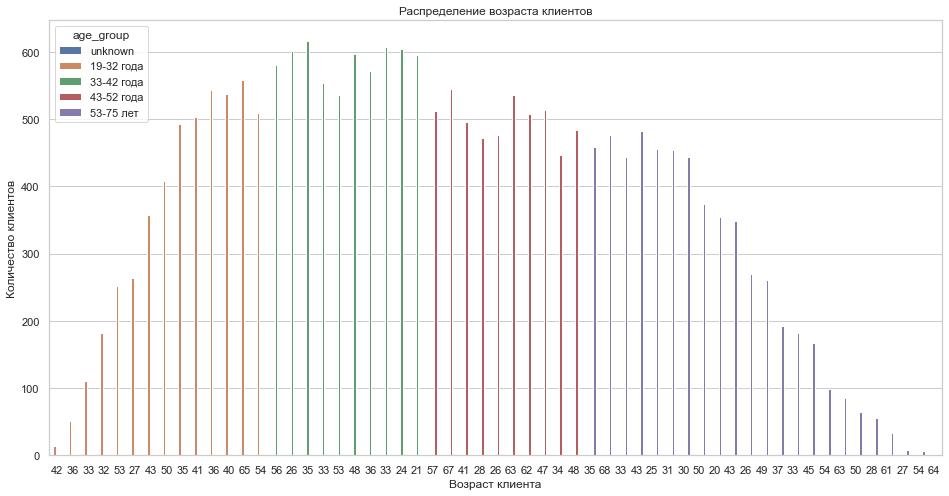

In [104]:
# Посмотрим на распределение клиентов по возрасту
ax = sns.countplot(df.age, hue=df.age_group)
plt.xlabel("Возраст клиента")
plt.ylabel('Количество клиентов')
plt.title('Распределение возраста клиентов')
ax.set_xticklabels(labels=df[df.age.notna()].age.astype('int'))
plt.show()

<a name="stage_3"></a>
# 3. Ответы на вопросы


[Наверх к оглавлению](#contents)

## 3.1 Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [105]:
# Для начала посмотрим на долю клиентов, у которых возникали задолжности, в зависимости от количества детей
children_debt = df.pivot_table(index = 'children_group',
               values = 'debt',
               aggfunc='mean')
children_debt

,debt
children_group,
нет детей,0.075454
1 ребенок,0.091471
2 детей,0.094499
3 и более детей,0.081579


Text(0.5, 1.0, 'График зависимсоти возникновения задолжности от количества детей клиента')

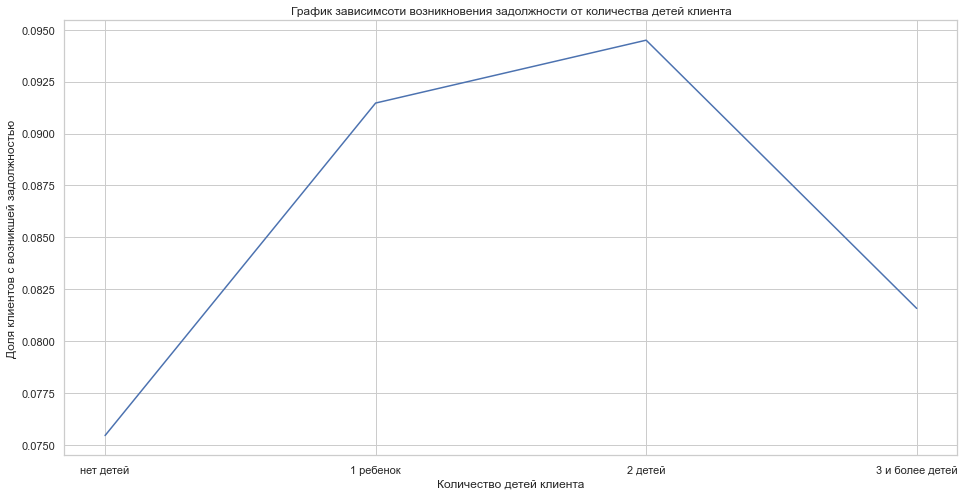

In [106]:
# отобразим полученную зависимость
sns.lineplot(x=children_debt.index, y=children_debt['debt'])
plt.xlabel("Количество детей клиента")
plt.ylabel('Доля клиентов с возникшей задолжностью')
plt.title('График зависимсоти возникновения задолжности от количества детей клиента')

Судя по полученным значениям, зависимость есть. Но делать вывод только по средним значениям – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Проверим две гипотезы:
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

Есть две категориальные переменные → посчитаем хи-квадрат

In [107]:
stat, p, dof, expected = st.chi2_contingency(pd.crosstab(df.children_group, df.debt))

In [108]:
# Посмотрим на результат
stat, p

(18.161493918976003, 0.00040737124921967296)

При условии, что верна нулевая гипотеза, вероятность получить такие или еще более значимые различия 99,99%.
Отклоняем нулевую гипотезу Но и делаем вывод, что взаимосвязь между переменными есть.

## 3.2 Есть ли зависимость между семейным положение и возвратом кредита в срок?

In [109]:
# Для начала посмотрим на долю клиентов, у которых возникали задолжности, в зависимости от их семейного положения
df.pivot_table(index = 'family_status',
               values = 'debt',
               aggfunc='mean')

,debt
family_status,
в разводе,0.071130
вдовец / вдова,0.065693
гражданский брак,0.093517
женат / замужем,0.075302
не женат / не замужем,0.097544


Судя по полученным значениям, зависимость есть. Но делать вывод только по средним значениям – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Проверим две гипотезы:
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

Есть две категориальные переменные → посчитаем хи-квадрат

In [110]:
stat, p, dof, expected = st.chi2_contingency(pd.crosstab(df.family_status, df.debt))

In [111]:
# Посмотрим на результат
stat, p

(28.996672953277837, 7.829563610246175e-06)

При условии, что верна нулевая гипотеза, вероятность получить такие или еще более значимые различия 99,99%.
Отклоняем нулевую гипотезу Но и делаем вывод, что взаимосвязь между переменными есть.

## 3.3 Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [112]:
# Подготовим данные
df_income_debt = df[df['month_income'].notna()]

In [113]:
# Для ответа на поставленный вопрос, разделим клиентов на 2 группы, в зависимости от наличия задолжности
# и посмотрим на описательные статистики зарплаты у двух групп
df_income_debt.pivot(values = 'month_income', columns = 'debt').describe()

debt,0,1
count,17777.000000,1569.000000
mean,167.803988,163.235564
std,103.011807,102.520315
min,21.200000,20.700000
25%,103.000000,104.600000
50%,145.200000,143.400000
75%,204.500000,194.600000
max,2265.600000,2200.900000


In [114]:
# Проверяем гомогенность дисперсий
st.levene(df_income_debt.query('debt == 0').month_income.sample(1500, replace=False),
          df_income_debt.query('debt == 1').month_income)

LeveneResult(statistic=4.373967127112141, pvalue=0.036574014191969505)

In [115]:
# Проверяем распределение каждой группы на нормальность по тесту Шапиро - Уилка.
# делаем выборки из наших наблюдений т.к. данный тест становится очень чувствительным при больших выборках
st.shapiro(df_income_debt.query('debt == 0').month_income.sample(1000))

ShapiroResult(statistic=0.7352001667022705, pvalue=4.099761204662528e-37)

In [116]:
st.shapiro(df_income_debt.query('debt == 1').month_income.sample(1000))

ShapiroResult(statistic=0.6135243773460388, pvalue=1.7292023049768243e-42)

По результатам тестов, делаем вывод, что дисперсии двух групп не различаются, но распределение далеко от нормального. Для определения статистической значимости различий между двумя группами используем парный t-тест.

Проверим две гипотезы:
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [117]:
stat, p = st.ttest_ind(df_income_debt.query('debt == 0').month_income.sample(1500, replace=False),
                          df_income_debt.query('debt == 1').month_income)

In [118]:
# Посмотрим на результат
stat, p

(0.17655339856725605, 0.8598708584658594)

При условии, что верна нулевая гипотеза, вероятность получить такие или еще более значимые различия 90,8%.
При такой вероятности, мы не можем отклонить нулевую гипотезу и делаем вывод, что взаимосвязи между переменными нет. Т.е. зависимости между уровнем дохода и возвратом кредита в срок нет.

Попробуем найти зависимость между категориальной переменной уровня дохода и возвратом кредита в срок.

In [119]:
# Для начала посмотрим на долю клиентов, у которых возникали задолжности, в зависимости от их уровня дохода
pivot_income_debt = df.pivot_table(index = 'month_income_group',
               values = 'debt',
               aggfunc='mean')
pivot_income_debt

,debt
month_income_group,
минимальный,0.078589
ниже среднего,0.087236
выше среднего,0.088071
очень высокий,0.070527


Text(0.5, 1.0, 'График зависимсоти возникновения задолжности от уровня заработной платы')

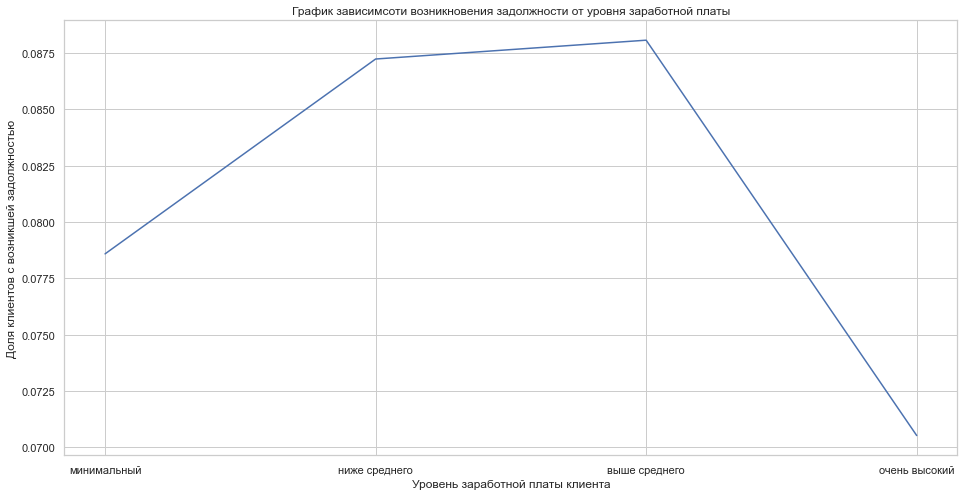

In [120]:
# отобразим полученную зависимость
sns.lineplot(x=pivot_income_debt.index, y=pivot_income_debt['debt'])
plt.xlabel("Уровень заработной платы клиента")
plt.ylabel('Доля клиентов с возникшей задолжностью')
plt.title('График зависимсоти возникновения задолжности от уровня заработной платы')

Судя по полученным значениям, зависимость есть. Но делать вывод только по средним значениям – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Проверим две гипотезы:
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

Есть две категориальные переменные → посчитаем хи-квадрат

In [121]:
stat, p, dof, expected = st.chi2_contingency(pd.crosstab(df.loc[df.month_income_group.notna(), 'month_income_group'],
                                                         df.loc[df.month_income_group.notna(), 'debt']))

In [122]:
# Посмотрим на результат
stat, p

(13.254309891860737, 0.0041177105185382255)

При условии, что верна нулевая гипотеза, вероятность получить такие или еще более значимые различия 99,99%.
Отклоняем нулевую гипотезу Но и делаем вывод, что взаимосвязь между переменными есть.

## 3.4 Как разные цели кредита влияют на его возврат в срок?

In [123]:
# Для начала посмотрим на долю клиентов, у которых возникали задолжности, в зависимости от целей кредита
df.pivot_table(index = 'purpose_group',
               values = 'debt',
               aggfunc='mean')

,debt
purpose_group,
автомобиль,0.093380
недвижимость,0.072268
образование,0.092200
свадьба,0.080034


Судя по полученным значениям, зависимость между целями кредита и его возвратом в срок есть. Но делать вывод только по сводной таблице – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Проверим две гипотезы:
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

Есть две категориальные переменные → посчитаем хи-квадрат

In [124]:
stat, p, dof, expected = st.chi2_contingency(pd.crosstab(df.purpose_group, df.debt))

In [125]:
# Посмотрим на результат
stat, p

(26.700514007553053, 6.802893807640178e-06)

При условии, что верна нулевая гипотеза, вероятность получить такие или еще более значимые различия 99,99%.
Отклоняем нулевую гипотезу Но и делаем вывод, что взаимосвязь между переменными есть.

<a name="stage_4"></a>
# 4. Результаты исследования


[Наверх к оглавлению](#contents)

Общие выводы:
    1. Была обнаружена статистически значимая зависимость между наличием детей у клиента и возвратом кредита в срок. Причем график зависимости имеет форму перевернутой пароболы, в которой наилучший показатель платежеспособности приходится на клиентов имеющих 1 и 2х детей, а у клиентов без детей и от 3х детей показатель платежеспособности хуже. Вероятно клиенты без детей и с количеством детей от 3х, имеют менее стабильную жизнь, поэтому и возникают проблемы с выплатами.
    2. Была обнаружена статистически значимая зависимость между семейным положением клиента и возвратом кредита в срок. Как ни странно, клиенты состоящие в браке имеют платежеспособность хуже, чем те кто в браке не состоят или состоят в гражданском браке. Хуже всего платежеспособность у вдовцов/вдов, что вполне логично.
    3.  Была обнаружена статистически значимая зависимость между уровнем дохода и возвратом кредита в срок.
    4. Была обнаружена статистически значимая зависимость между целями кредита и его возвратом в срок. Причем наихудший показатель платежеспособности у тех, кто берет кредит с целью приобретения недвижимости. Это тоже звучит вполне логично, т.к. для этих целей берут кредиты на довольно продолжительный период времени, в течении которого люди могут столкнуться с большим количеством факторов, повлиявших на их платежеспособность.

Рекомендации:
1. В данных очень много ошибок, связанных с человеческим фактором: неправильно заполненны стаж работы, количество детей и прочее. Необходимо отладить систему записи информации о клиентах, чтобы система не давала заносить в базу некорректные данные.
2. Необходимо внести дополнительную информацию о сфере работы клиентов, должности, сумме ежемесячного платежа и прочее. Т.к. эти факторы были бы полезны при анализе платежеспособности.
3. При построении модели кредитного скоринга, необходимо учесть наличие зависимостей платежеспособности клиентов с другими факторами, которые мы не рассмотрели в рамках проекта. Также необходимо учесть взаимозависимость всех факторов. Возможно клиенты в разводе, без детей и с целью покупки жилья, могут совсем низкую платежеспособность.